In [2]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt

import glob
import xarray as xr
import datetime

In [3]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [5]:
dtype = torch.complex64  # fft required data type

In [6]:
def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

# Pick the Dataset

In [7]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [8]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [9]:
f_sel = 40
dataFile = file_list[f_sel]

In [10]:
h_ds = xr.open_dataset(dataFile)

# Build Output Map For Labels

In [11]:
n_bins = 1000  # number of bins in histogram
n_holograms = 1000  # number of holograms to use in data set
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers
hologram_slice = slice(None,2*n_holograms)

In [12]:
histogram_lst = []
for holo_idx in h_ds['hologram_number'].values[hologram_slice]:
    hist_tpl = np.histogram(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],bins=z_bins)
    histogram_lst.append(hist_tpl[0])

Text(0.5, 0, 'z position [$\\mu m$]')

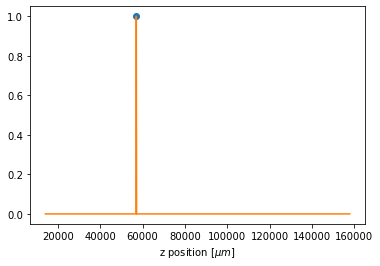

In [13]:
# confirm histogram and particle data are aligned
plt.figure()
plt.plot(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],np.ones(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)].shape),'o')
plt.plot(z_centers,histogram_lst[holo_idx])
plt.xlabel('z position [$\mu m$]')

In [14]:
histogram_arr = np.stack(histogram_lst,axis=0)
train_histogram_bin_arr = (histogram_arr[:n_holograms,:]>0).astype(float)
valid_histogram_bin_arr = (histogram_arr[n_holograms:,:]>0).astype(float)

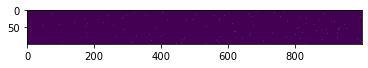

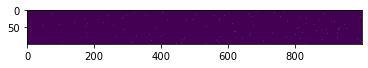

In [15]:
plt.figure()
plt.imshow(histogram_arr[0:100,:])
plt.figure()
plt.imshow(train_histogram_bin_arr[0:100,:])

# Build Reconstructed Plane Inputs

In [16]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [17]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [18]:
fx = torch.fft.fftfreq(Nx,dx,device=device)[None,:,None]
fy = torch.fft.fftfreq(Ny,dy,device=device)[None,None,:]
z_rec = torch.tensor(z_centers*1e-6,device=device)[:,None,None]

Test Reconstruction Assumptions

(1, 600, 400)
(600,)
(400,)


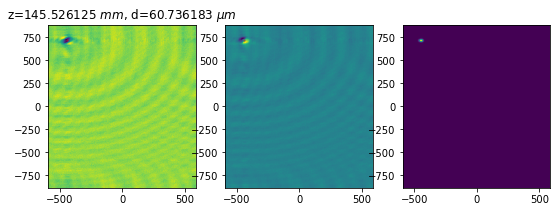

In [19]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]
z_plane = torch.tensor(zp*1e-6,device=device)[:,None,None]
E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
Eres = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

z_idx = np.digitize(zp,bins=z_bins)-1

z_maps = np.zeros((z_centers.size,)+h_ds['image'].shape[1:])

for p_idx,iz in enumerate(z_idx):
    z_maps[iz,:,:] += np.exp(-(y_arr[None,:]*1e6-yp[p_idx])**2/(2*(10)**2) - (x_arr[:,None]*1e6-xp[p_idx])**2/(2*(10)**2) )
    
    

print(Eres.shape)
print(x_arr.shape)
print(y_arr.shape)

for idx,z in enumerate(zp):
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,np.abs(Eres[idx,:,:]))
    ax[0].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,np.angle(Eres[idx,:,:]))
    ax[1].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)
    iz = np.argmin(np.abs(z_centers-z))
    ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,z_maps[iz,:,:])
#     ax[2].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)

In [20]:
marker_size = 10  # gaussian marker size in micro meters
gaus_mult = 1   # multiplier to apply to gaussian (to increase effect in loss function)

Eset = []
# Eset1 = []
# Eset2 = []
histset = []
z_map_lst = []
start_time = datetime.datetime.now()
for holo_idx in range(2*n_holograms):
    part_idx = np.where(histogram_arr[holo_idx,:] > 0)[0]
    empt_idx = np.where(histogram_arr[holo_idx,:] == 0)[0]
    set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
    set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
    z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate([set_part,set_empt])],device=device)[:,None,None]
    
    # build UNET output mask
    p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
    xp = h_ds['x'].values[p_idx]
    yp = h_ds['y'].values[p_idx]
    zp = h_ds['z'].values[p_idx]
    dp = h_ds['d'].values[p_idx]
    
    z_maps = np.zeros((set_part.size+set_empt.size,)+h_ds['image'].shape[1:])
    
    z_idx = np.digitize(zp,bins=z_bins)-1
    for ip,iz in enumerate(z_idx):
        if iz in set_part:
            map_idx = np.where(iz == set_part)[0]
            z_maps[map_idx,:,:] += gaus_mult*np.exp(-(y_arr[None,:]*1e6-yp[ip])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-xp[ip])**2/(2*marker_size**2) )
            
    z_map_lst.append(torch.tensor(z_maps))
    
    
    
    # reconstruct the image
    image_in = h_ds['image'].isel(hologram_number=holo_idx).values
    image_in = image_in/image_in.max()
    E_input = torch.tensor(image_in,device=device,dtype=dtype)[None,:,:] 
    Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu()
    Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))
#     Eset1.append(Eres[:,None,:,:].abs())
#     Eset2.append(Eres[:,None,:,:].angle())
    histset.append(histogram_arr[holo_idx,np.concatenate([set_part,set_empt])])

#     # Include All Reconstructions
#     E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
#     Eres = torch_holo_set(E_input,fx,fy,z_rec,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
#     # Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))


end_time = datetime.datetime.now()

In [21]:
print(z_idx)
print(zp)

[298]
[57026.67]


In [22]:
exec_time = end_time-start_time
print(f'executed {2*num_per_holo*len(Eset)} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/(2*num_per_holo*len(Eset))} seconds per plane')

# exec_time = end_time-start_time
# print(f'executed {z_centers.size*len(Eset)} planes in {exec_time.total_seconds()} seconds')
# print(f' for {exec_time.total_seconds()/(z_centers.size*len(Eset))} seconds per plane')

executed 4000 planes in 31.18246 seconds
 for 0.007795615 seconds per plane


In [23]:
idx_arr = np.arange(len(Eset)).astype(int)
train_idx = np.random.choice(idx_arr, idx_arr[-1]//2 ,replace=False)
valid_idx = np.delete(idx_arr,train_idx)

In [24]:
train_inputs = torch.cat(Eset,dim=0)[train_idx,...]
valid_inputs = torch.cat(Eset,dim=0)[valid_idx,...]

# train_inputs1 = torch.cat(Eset1,dim=0)[train_idx,...]
# valid_inputs1 = torch.cat(Eset1,dim=0)[valid_idx,...]
# train_inputs2 = torch.cat(Eset2,dim=0)[train_idx,...]/np.pi
# valid_inputs2 = torch.cat(Eset2,dim=0)[valid_idx,...]/np.pi

In [25]:
z_map_tns = torch.cat(z_map_lst,dim=0)[:,None,:,:]

In [26]:
train_labels = z_map_tns[train_idx,...]
valid_labels = z_map_tns[valid_idx,...]

In [27]:
hist_labels = np.concatenate(histset)

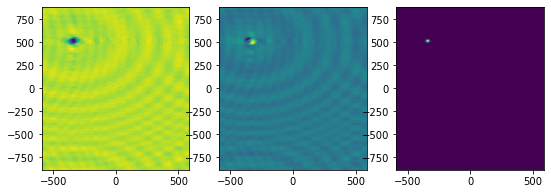

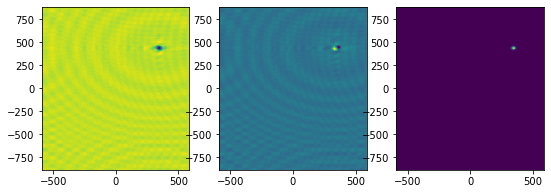

In [28]:
idx = np.where(hist_labels[train_idx]>0)[0][3]
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,train_inputs[idx,0,:,:])
ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,train_inputs[idx,1,:,:])
ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,train_labels[idx,0,:,:])


idx = np.where(hist_labels[valid_idx]>0)[0][4]
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,0,:,:])
ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,1,:,:])
ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_labels[idx,0,:,:])

In [29]:
train_inputs.max()

tensor(1.1474, dtype=torch.float64)

In [30]:
conv_size = 7
pool_stride = 4
print(train_inputs.float()[5:6,...].shape)
x1 = nn.Conv2d(2, 4, conv_size,padding=(conv_size-1)//2)(train_inputs.float()[5:6,...]) # ,padding=(conv_size-1)//2
print(x1.shape)
print()
x2 = nn.MaxPool2d(pool_stride, pool_stride)(x1)
print(x2.shape)
x3 = nn.ConvTranspose2d(4, 2, conv_size-pool_stride//2, stride=pool_stride, padding=(conv_size-1-pool_stride//2)//2)(x2) # 
print(x3.shape)

torch.Size([1, 2, 600, 400])
torch.Size([1, 4, 600, 400])

torch.Size([1, 4, 150, 100])
torch.Size([1, 2, 597, 397])


# Build Model

In [31]:
epochs = 100
optimizer_type = "adam"
learning_rate = 1e-5
batch_size = 64
dtype = torch.float

In [32]:
# train_labels = torch.tensor(train_histogram_bin_arr.reshape(-1,1),dtype=dtype)
# valid_labels = torch.tensor(valid_histogram_bin_arr.reshape(-1,1),dtype=dtype)

# ### TODO ###
# train_labels = torch.tensor(hist_labels[train_idx],dtype=dtype)[:,None]
# valid_labels = torch.tensor(hist_labels[valid_idx],dtype=dtype)[:,None]

In [33]:
train_labels.shape

torch.Size([999, 1, 600, 400])

In [34]:
def element_weighted_MSELoss(y_hat, y):
    weights = y ** 2
    criterion = torch.nn.MSELoss(reduction='none')
    loss = criterion(y_hat, y)
    loss = loss * ( (1-1e-4)*weights + 1e-4 )
    return loss.sum() / weights.sum()

In [35]:
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
# loss_fn = nn.MSELoss()
loss_fn = element_weighted_MSELoss

In [36]:
input_shape = train_inputs.shape[1:]
output_shape = train_labels.shape[1:]
print(input_shape)
print(output_shape)

torch.Size([2, 600, 400])
torch.Size([1, 600, 400])


In [37]:
PoolStride = 2  # don't change this.  I haven't figured out how to match of dims with other strides
ConvSize = 3

In [38]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ConvSize, padding=(ConvSize-1)//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=ConvSize, padding=(ConvSize-1)//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# class DownSamp(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DownSamp, self).__init__()
#         self.doub_conv = DoubleConv(in_channels,out_channels)
#         self.pool = nn.MaxPool2d(PoolStride, PoolStride)

#     def forward(self, x):
#         return self.pool(self.doub_conv(x))
    
# class UpSamp(nn.Module):
#     def __init__(self, in_channels, mid_channels, out_channels):
#         super(UpSamp, self).__init__()
#         self.conv_transp = nn.ConvTranspose2d(in_channels, 
#                                             in_channels, 
#                                             ConvSize-PoolStride//2 , 
#                                             stride=PoolStride, 
#                                             padding=(ConvSize-1-PoolStride//2)//2)
#         self.doub_conv = DoubleConv(mid_channels,out_channels)

#     def forward(self, x, xf):
#         return self.doub_conv(torch.cat([self.conv_transp(x),xf],dim=1))

In [39]:
# ResNet 50 notebook : /glade/work/schreck/repos/goes16ci/gunther_notebook/latest.ipynb



class XY_Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = DoubleConv(2, 4)
        self.conv2d = DoubleConv(4, 8)
        self.conv3d = DoubleConv(8, 16)
        self.conv4d = DoubleConv(16, 32)
#         self.conv5d = DoubleConv(32, 64)
        
#         self.convT4u = nn.ConvTranspose2d(64, 64, ConvSize-PoolStride//2, 
#                                             stride=PoolStride, 
#                                             padding=(ConvSize-1-PoolStride//2)//2)
        
#         self.conv4u = DoubleConv(32+64, 32)
        
        self.convT3u = nn.ConvTranspose2d(32, 32, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        
        self.conv3u = DoubleConv(16+32, 16)
        
        self.convT2u = nn.ConvTranspose2d(16, 16, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        
        self.conv2u = DoubleConv(8+16, 8)
        
        self.convT1u = nn.ConvTranspose2d(8, 8, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        self.conv1u = DoubleConv(4+8, 4)
    
        
        self.pool = nn.MaxPool2d(PoolStride, PoolStride)
        
        self.conv_out = nn.Conv2d(4, 1, 1)
        

    def forward(self, x):
        x1 = self.conv1d(x)
        x2 = self.conv2d(self.pool(x1))
        x3 = self.conv3d(self.pool(x2))
        x4 = self.conv4d(self.pool(x3))
#         x5 = self.conv5d(self.pool(x4))

#         x4 = torch.cat([self.convT4u(x5),x4],dim=1)
#         x4 = self.conv4u(x4)
        x3 = torch.cat([self.convT3u(x4),x3],dim=1)
        x3 = self.conv3u(x3)
        x2 = torch.cat([self.convT2u(x3),x2],dim=1)
        x2 = self.conv2u(x2)
        x1 = torch.cat([self.convT1u(x2),x1],dim=1)
        x1 = self.conv1u(x1)
        
        return F.sigmoid(self.conv_out(x1))

    


In [40]:
unet_model = XY_Unet()
unet_model.to(device)

XY_Unet(
  (conv1d): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2d): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv3d): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 16, k

In [41]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(unet_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(unet_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )

In [42]:
train_ds = TensorDataset(train_inputs.float().to(device), train_labels.float().to(device))
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(valid_inputs.float().to(device), valid_labels.float().to(device))
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [43]:
train_loss_hist = []
valid_loss_hist = []

In [44]:
epochs=150

In [ ]:
batches_per_epoch = len(train_dl)+1


for epoch in range(epochs):
    train_loss = 0
    unet_model.train()
    for batch_idx,(xb,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch,leave=True):
        pred = unet_model(xb)
        loss = loss_fn(pred*gaus_mult, yb)
        train_loss += loss.sum().to('cpu').item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        unet_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(unet_model(xb)*gaus_mult, yb) for xb, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss / len(train_dl), valid_loss.item() / len(valid_dl))

  6%|▌         | 1/17 [00:00<00:02,  7.91it/s]

0 0.5409168172627687 0.5207948088645935


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

1 0.5332431457936764 0.5104141235351562


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

2 0.5270396899431944 0.5004576444625854


  6%|▌         | 1/17 [00:00<00:01,  8.75it/s]

3 0.5152390468865633 0.49184733629226685


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

4 0.5093416515737772 0.4841446876525879


  6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

5 0.5003259889781475 0.4776363670825958


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

6 0.4980441089719534 0.4724079966545105


  6%|▌         | 1/17 [00:00<00:01,  8.76it/s]

7 0.49483340978622437 0.46718552708625793


  6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

8 0.4819418005645275 0.4627115726470947


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

9 0.4795254021883011 0.45832696557044983


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

10 0.476024866104126 0.4540586471557617


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

11 0.4705018326640129 0.45009878277778625


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

12 0.4666262920945883 0.44640132784843445


  6%|▌         | 1/17 [00:00<00:01,  8.82it/s]

13 0.4695967361330986 0.44296252727508545


  6%|▌         | 1/17 [00:00<00:01,  8.81it/s]

14 0.4620972629636526 0.43942099809646606


  6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

15 0.4621367398649454 0.43626466393470764


  6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

16 0.4553797636181116 0.4331238269805908


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

17 0.47422152012586594 0.43062177300453186


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

18 0.4489899016916752 0.42879000306129456


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

19 0.45383026637136936 0.42655259370803833


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

20 0.4463999327272177 0.42440903186798096


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

21 0.4452673476189375 0.42256778478622437


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

22 0.4448696952313185 0.42028355598449707


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

23 0.4379254952073097 0.41856327652931213


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

24 0.4415297657251358 0.41793155670166016


  6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

25 0.4376157131046057 0.4162248969078064


  6%|▌         | 1/17 [00:00<00:01,  8.75it/s]

26 0.4413648974150419 0.41539403796195984


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

27 0.4421968553215265 0.4150712192058563


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

28 0.43756923265755177 0.41474148631095886


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

29 0.43639553524553776 0.41476115584373474


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

30 0.4388276282697916 0.4154181480407715


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

31 0.43934131413698196 0.4159119129180908


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

32 0.4425257798284292 0.41657376289367676


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

33 0.440990436822176 0.41705432534217834


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

34 0.4451024830341339 0.4173746705055237


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

35 0.4401324801146984 0.41795477271080017


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

36 0.4416563231498003 0.4198310971260071


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

37 0.45001958683133125 0.42025473713874817


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

38 0.44285070709884167 0.42039954662323


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

39 0.44476001150906086 0.42135366797447205


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

40 0.44890122301876545 0.4226357340812683


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

41 0.4461941570043564 0.42364680767059326


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

42 0.4466809146106243 0.4247758984565735


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

43 0.44536769203841686 0.42529284954071045


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

44 0.4481645468622446 0.42628544569015503


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

45 0.45262742042541504 0.4267827868461609


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

46 0.450622858479619 0.4274097681045532


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

47 0.45019047148525715 0.4266361892223358


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

48 0.44842993654310703 0.42688247561454773


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

49 0.4490526672452688 0.4263404607772827


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

50 0.449019692838192 0.4269678294658661


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

51 0.4535738080739975 0.4268699884414673


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

52 0.44760454818606377 0.42637351155281067


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

53 0.4514106325805187 0.42702725529670715


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

54 0.4503533486276865 0.42591190338134766


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

55 0.4504851009696722 0.42689281702041626


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

56 0.4467573892325163 0.4260042905807495


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

57 0.44806901551783085 0.4265700876712799


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

58 0.46026475355029106 0.4258442521095276


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

59 0.44598344527184963 0.4252101182937622


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

60 0.44978917948901653 0.4253007769584656


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

61 0.4502023570239544 0.4235278367996216


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

62 0.43974658846855164 0.42066001892089844


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

63 0.4390153717249632 0.41970470547676086


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

64 0.44431142322719097 0.4188893735408783


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

65 0.43735993281006813 0.4182683229446411


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

66 0.438335994258523 0.4176151156425476


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

67 0.44174095802009106 0.4165698289871216


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

68 0.4331483393907547 0.414703905582428


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

69 0.43855723552405834 0.41374504566192627


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

70 0.4330251570791006 0.41261646151542664


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

71 0.43401747941970825 0.4111612141132355


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

72 0.42960418574512005 0.4094807505607605


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

73 0.42891494184732437 0.40878844261169434


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

74 0.4234093986451626 0.4065121114253998


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

75 0.4254786539822817 0.40464043617248535


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

76 0.4244969617575407 0.40397268533706665


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

77 0.4211285524070263 0.4017048478126526


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

78 0.4213669691234827 0.3981578052043915


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

79 0.4166394993662834 0.39715394377708435


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

80 0.4203066322952509 0.39596039056777954


  6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

81 0.4156056307256222 0.39536288380622864


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

82 0.41112389229238033 0.3916335105895996


  6%|▌         | 1/17 [00:00<00:01,  9.00it/s]

83 0.416550375521183 0.39010414481163025


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

84 0.4096869621425867 0.38918688893318176


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

85 0.4089440405368805 0.3865881860256195


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

86 0.4046384170651436 0.38500550389289856


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

87 0.4042669180780649 0.3834177553653717


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

88 0.40302992425858974 0.3811604678630829


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

89 0.4015328548848629 0.37860777974128723


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

90 0.3979467488825321 0.37695634365081787


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

91 0.4030715376138687 0.37538182735443115


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

92 0.3931848257780075 0.37148284912109375


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

93 0.389107683673501 0.36847400665283203


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

94 0.3860182110220194 0.3648771047592163


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

95 0.3827095180749893 0.36024561524391174


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

96 0.38082688860595226 0.3545945882797241


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

97 0.3742018807679415 0.3498055040836334


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

98 0.36699108593165874 0.3453649878501892


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

99 0.36652691289782524 0.3410454988479614


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

100 0.3614634368568659 0.33558890223503113


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

101 0.3535601459443569 0.3292470872402191


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

102 0.34764548018574715 0.3206802010536194


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

103 0.3418310768902302 0.31572094559669495


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

104 0.3379023037850857 0.30948251485824585


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

105 0.3358079884201288 0.30421459674835205


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

106 0.33010602183640003 0.29854023456573486


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

107 0.32150390464812517 0.29162701964378357


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

108 0.3162483451887965 0.2836044132709503


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

109 0.30425084196031094 0.27470073103904724


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

110 0.2975087473168969 0.2679442763328552


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

111 0.28995624650269747 0.2596845328807831


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

112 0.28260618820786476 0.25209373235702515


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

113 0.27965583465993404 0.2458338439464569


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

114 0.27279124315828085 0.23919737339019775


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

115 0.269193559885025 0.23308952152729034


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

116 0.2548842076212168 0.22620853781700134


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

117 0.25097208842635155 0.21720588207244873


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

118 0.2388594951480627 0.2087571769952774


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

119 0.2345636822283268 0.20233188569545746


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

120 0.23288351576775312 0.19593676924705505


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

121 0.21863259468227625 0.18863028287887573


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

122 0.21202236600220203 0.18361379206180573


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

123 0.21026068553328514 0.1782987117767334


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

124 0.202016887255013 0.17589330673217773


  6%|▌         | 1/17 [00:00<00:01,  8.97it/s]

125 0.19615999329835176 0.16927209496498108


  6%|▌         | 1/17 [00:00<00:01,  8.93it/s]

126 0.1885712267830968 0.16254958510398865


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

127 0.18833864759653807 0.15734754502773285


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

128 0.1783255049958825 0.1511887162923813


  6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

129 0.17921985406428576 0.14768798649311066


  6%|▌         | 1/17 [00:00<00:01,  8.93it/s]

130 0.1717086429707706 0.14266511797904968


  6%|▌         | 1/17 [00:00<00:01,  8.89it/s]

131 0.1685597114264965 0.1398024708032608


  6%|▌         | 1/17 [00:00<00:01,  8.91it/s]

132 0.16515936935320497 0.13970084488391876


  6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

133 0.17101842164993286 0.13732139766216278


  6%|▌         | 1/17 [00:00<00:01,  8.86it/s]

134 0.16026977682486176 0.13631676137447357


  6%|▌         | 1/17 [00:00<00:01,  8.88it/s]

135 0.15243638679385185 0.13392330706119537


  6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

136 0.1633332776837051 0.13518951833248138


  6%|▌         | 1/17 [00:00<00:01,  8.86it/s]

137 0.1561860623769462 0.135635107755661


  6%|▌         | 1/17 [00:00<00:01,  8.88it/s]

138 0.16096431761980057 0.13306300342082977


  6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

139 0.1564941401593387 0.1354297399520874


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

140 0.15921419812366366 0.13206282258033752


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

141 0.1595903132110834 0.1325598657131195


  6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

142 0.16175481071695685 0.1354466676712036


  6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

143 0.15514612011611462 0.1327047199010849


  6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

144 0.15909771341830492 0.13344550132751465


 94%|█████████▍| 16/17 [00:04<00:00,  3.29it/s]


In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

In [46]:
valid_sets = []
with torch.no_grad():
    for xv, yv in valid_dl:
        valid_sets.append([unet_model(xv).detach().cpu().numpy(), yv.detach().cpu().numpy(), xv.detach().cpu().numpy()])

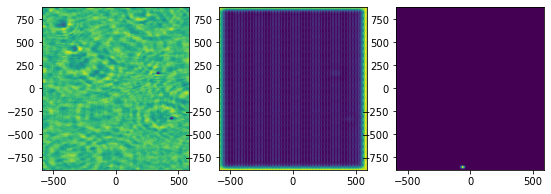

In [47]:
vld_idx = 4
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][2][vld_idx,0,...])
ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][0][vld_idx,0,...])
ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][1][vld_idx,0,...])

In [100]:
np.sum(valid_sets[0][0][2,0,...])

111800.12

In [101]:
ypred = unet_model(xb)
print(yb.shape)

torch.Size([39, 1, 600, 400])


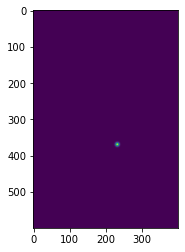

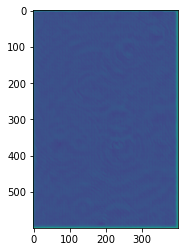

In [102]:
plt.figure()
plt.imshow(yb[0,0,...].cpu().detach().numpy())

plt.figure()
plt.imshow(ypred[0,0,...].cpu().detach().numpy())

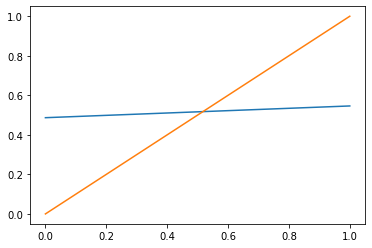

In [39]:
plt.figure()
plt.plot(valid_sets[1][0])
plt.plot(valid_sets[1][1])

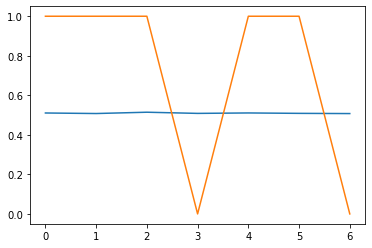

In [40]:
plt.figure()
plt.plot(pred.detach().cpu().numpy())
plt.plot(yb.detach().cpu().numpy())

In [108]:
h_ds

<xarray.Dataset>
Dimensions:         (hologram_number: 50000, particle: 500000, patch_number: 800000, patch_xsize: 128, patch_ysize: 128, xsize: 512, ysize: 512)
Dimensions without coordinates: hologram_number, particle, patch_number, patch_xsize, patch_ysize, xsize, ysize
Data variables: (12/16)
    hid             (particle) float32 1.0 1.0 1.0 1.0 ... 5e+04 5e+04 5e+04
    d               (particle) float32 36.48 45.38 25.82 ... 32.3 9.01 40.48
    x               (particle) float32 253.9 22.78 732.8 ... -616.6 -431.8
    y               (particle) float32 708.5 -600.7 552.2 ... 106.1 -190.7 662.5
    z               (particle) float32 5.645e+04 1.438e+05 ... 1.419e+05
    n0              (particle) float32 ...
    ...              ...
    x_pixels        (particle) float32 ...
    y_pixels        (particle) float32 ...
    pid             (particle) float32 ...
    x_patch_pixels  (particle) float32 ...
    y_patch_pixels  (particle) float32 ...
    patch           (patch_number, patch_xsize, patch_ysize) uint8 ...
Attributes: (12/33)
    DateCreated:           10-Feb-2021
    Nx:                    512.0
    Ny:                    512.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    monodisperse:          0.0
    should_cache:          1
    Nx_patch:              128.0
    Ny_patch:              128.0
    nPatches:              800000.0
    PatchesPerHologram:    16.0